# Курсовой проект для курса "Python для Data Science"

**Задание:**
    
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).

С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

**Подключение библиотек и скриптов**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

## 1. Чтение данных

In [3]:
TRAIN_DATASET_PATH = './data/train.csv'
TEST_DATASET_PATH = './data/test.csv'
# PREPARED_DATASET_PATH = './data/train_prepared.csv'

### Загрузка данных

**Описание датасета**

Цены на недвижимость (квартиры).

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [4]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

train_df.set_index('Id', inplace=True)
test_df.set_index('Id', inplace=True)

train_df.shape, test_df.shape

((10000, 19), (5000, 18))

In [5]:
train_df.tail()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
77,32,2.00,50.40,30.48,5.00,6,5.00,1968,0.14,B,B,46,7960,6,350.00,3,11,B,"196,684.32"
6159,18,1.00,41.52,20.54,9.00,13,13.00,2000,0.00,B,B,30,5562,0,nan,0,5,A,"189,050.29"
5123,27,1.00,47.94,nan,1.00,12,16.00,2015,0.07,B,B,2,629,1,nan,0,0,A,"159,143.81"
5400,75,2.00,43.60,33.84,8.00,1,5.00,1961,0.31,B,A,30,5048,9,325.00,2,5,B,"181,595.34"
6306,128,1.00,38.67,21.16,8.00,7,17.00,1990,0.00,B,B,27,4798,0,30.00,2,8,B,"218,714.08"


### Получение информации о данных

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int64  
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     3959 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2      5000 non-null   object 
 10  Ecology_3      5000 non-null   object 
 11  Social_1       5000 non-null   int64  
 12  Social_2       5000 non-null   int64  
 13  Social_3       5000 non-null   int64  
 14  Healthcare_1   2623 non-null   float64
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   object 
dtypes: fl

In [8]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.00","10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00"
mean,50.40,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,"214,138.86"
std,43.59,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,"92,872.29"
min,0.00,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,20.00,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63"
50%,36.00,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64"
75%,75.00,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,"249,135.46"
max,209.00,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,"633,233.47"


In [9]:
train_df.describe(include='object')

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


### Обработка категориальных признаков

**DistrictId**

In [10]:
print(train_df['DistrictId'].nunique(), ' уникальных  значений DistrictId в обучающей выборке')
print(test_df['DistrictId'].nunique(), ' уникальных  значений DistrictId в тестовой выборке')

205  уникальных  значений DistrictId в обучающей выборке
201  уникальных  значений DistrictId в тестовой выборке


In [11]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

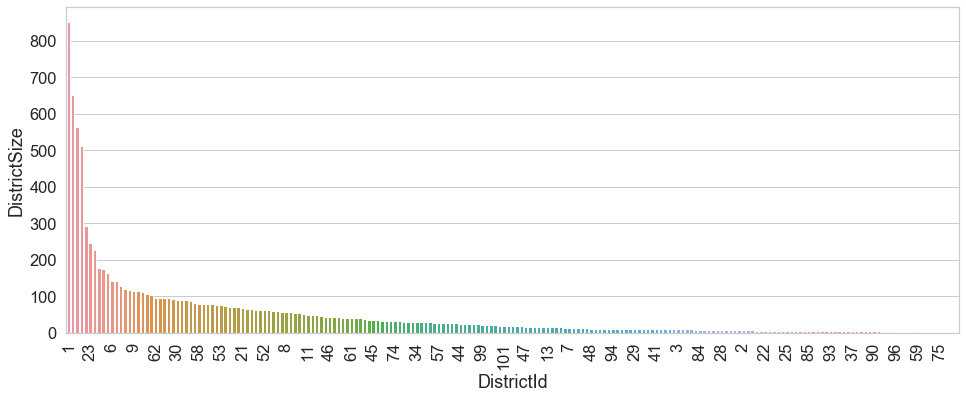

In [12]:
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y='DistrictSize', x='DistrictId', 
            data=district_size,
            order=district_size.sort_values(by='DistrictSize', ascending=False)['DistrictId']
           );
ax.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(50))

In [13]:
districts_popular = district_size.loc[district_size['DistrictSize'] > 100, 'DistrictId'].tolist()

Заменим DistrictId редких районов (с количеством квартир < 100) на номер 999.

In [14]:
district_size.loc[~district_size['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
district_size = district_size.groupby('DistrictId')['DistrictSize'].agg(
                           DistrictSize='median')
district_size.reset_index(level='DistrictId', inplace=True)
district_size

,DistrictId,DistrictSize
0,1,652
1,6,511
2,8,142
3,9,294
4,11,129
5,21,165
6,23,565
7,27,851
8,30,228
9,34,111


In [15]:
train_df.loc[~train_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
test_df.loc[~test_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999

In [16]:
# train_df['DistrictId'] = train_df['DistrictId'].astype(str)
# test_df['DistrictId'] = test_df['DistrictId'].astype(str)

**Ecology_2, Ecology_3, Shops_2**

In [17]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [18]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [19]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [20]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

train_df[feature_bin_names] = train_df[feature_bin_names].replace({'A':0, 'B':1})
test_df[feature_bin_names] = test_df[feature_bin_names].replace({'A':0, 'B':1})

### Обработка выбросов и пропусков

In [21]:
train_df.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [22]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,"10,000.00","10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,506.44,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,0.99,0.97,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,0.92,"214,138.86"
std,486.05,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,0.10,0.16,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,0.28,"92,872.29"
min,1.00,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,0.00,0.00,168.00,0.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,27.00,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,1.00,1.00,6.00,"1,564.00",0.00,350.00,0.00,1.00,1.00,"153,872.63"
50%,74.00,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,1.00,1.00,25.00,"5,285.00",2.00,900.00,1.00,3.00,1.00,"192,269.64"
75%,999.00,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,1.00,1.00,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,1.00,"249,135.46"
max,999.00,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,1.00,1.00,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,1.00,"633,233.47"


**Healthcare_1**

In [23]:
train_df['Healthcare_1'].value_counts().sort_values()

0.00          1
35.00         2
1,815.00     10
32.00        12
370.00       14
           ... 
229.00      148
750.00      163
1,046.00    245
30.00       348
540.00      511
Name: Healthcare_1, Length: 79, dtype: int64

In [24]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].median()
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

**Rooms**

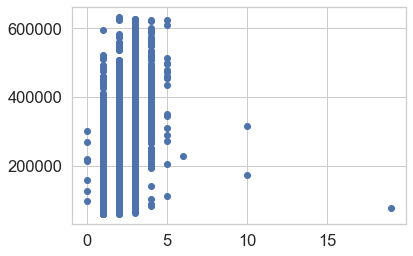

In [25]:
plt.scatter(train_df['Rooms'], train_df['Price']);

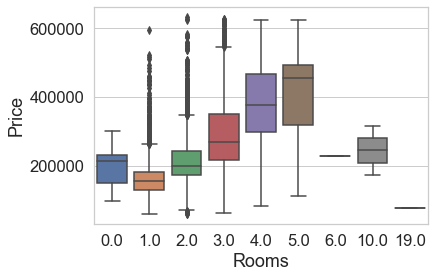

In [26]:
sns.boxplot(y='Price', x='Rooms', data=train_df)

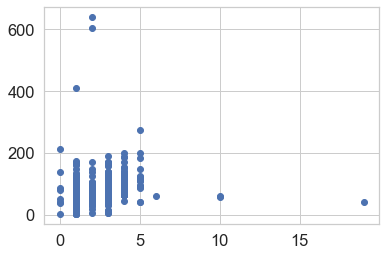

In [27]:
plt.scatter(train_df['Rooms'], train_df['Square'])

In [28]:
train_df['Rooms'].value_counts()

# > 5 комнат, = 0 комнат

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
19.00       1
6.00        1
Name: Rooms, dtype: int64

In [29]:
train_df['Rooms'].mode()[0]

2.0

In [30]:
# train_df.loc[(train_df['Rooms'] > 5)|(train_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0]
# test_df.loc[(test_df['Rooms'] > 5)|(test_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0] 

**Square, LifeSquare, KitchenSquare**

In [31]:
print(train_df['LifeSquare'].isna().sum(),' значений жилой площади отсутствуют')

print((train_df['LifeSquare'] > train_df['Square']).sum(), ' значений: жилая площадь больше общей площади')

condition_1 = (train_df['KitchenSquare'] <= 3) & (train_df['LifeSquare'].isna())
print(condition_1.sum(), ' значений: площадь кухни 3 кв.м и менее, при этом значения жилой площади отсутствуют')

condition_2 = (train_df['KitchenSquare'] <= 3) & (~train_df['LifeSquare'].isna())
print(condition_2.sum(), ' значений: площадь кухни 3 кв.м и менее, при этом имеются значения жилой площади')

print((train_df['KitchenSquare'] > train_df['Square']).sum(), ' значений: площадь кухни больше общей площади')

2113  значений жилой площади отсутствуют
482  значений: жилая площадь больше общей площади
1979  значений: площадь кухни 3 кв.м и менее, при этом значения жилой площади отсутствуют
1204  значений: площадь кухни 3 кв.м и менее, при этом имеются значения жилой площади
4  значений: площадь кухни больше общей площади


In [32]:
condition_3 = (train_df['KitchenSquare'] > (train_df['LifeSquare'] - train_df['Square'])) &\
    (train_df['LifeSquare'] > train_df['Square'])

print(condition_3.sum(), ' значений: жилая площадь больше общей площади, при этом площадь \
кухни больше разницы жилой и общей площади')

condition_4 = (train_df['KitchenSquare'] > (train_df['Square'] - train_df['LifeSquare'])) &\
    (train_df['Square'] > train_df['LifeSquare'])

print(condition_4.sum(), ' значений: общая площадь больше жилой площади, при этом площадь \
кухни больше разницы общей и жилой площади')

228  значений: жилая площадь больше общей площади, при этом площадь кухни больше разницы жилой и общей площади
363  значений: общая площадь больше жилой площади, при этом площадь кухни больше разницы общей и жилой площади


In [33]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","7,887.00","10,000.00"
mean,56.32,37.20,6.27
std,21.06,86.24,28.56
min,1.14,0.37,0.00
25%,41.77,22.77,1.00
50%,52.51,32.78,6.00
75%,65.90,45.13,9.00
max,641.07,"7,480.59","2,014.00"


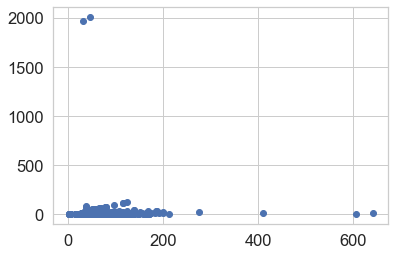

In [34]:
plt.scatter(train_df['Square'], train_df['KitchenSquare']);

# Площадь кухни > 250

In [35]:
# train_df.loc[(train_df['KitchenSquare'] > 80) | \
#             (train_df['KitchenSquare'] > train_df['Square']),
#             'KitchenSquare'] = train_df['KitchenSquare'].median()

# test_df.loc[(test_df['KitchenSquare'] > 80) | \
#            (test_df['KitchenSquare'] > test_df['Square']),
#            'KitchenSquare'] = train_df['KitchenSquare'].median()

# В Калифорнии, как правило, кухня не отдельная комната, а отгороженное место в жилой комнате. 
# Поэтому со значениями KitchenSquare <= 3 кв.м ничего не делаем.

In [36]:
# train_df.loc[(train_df['KitchenSquare'] <= train_df['Square'] * 0.4) & (train_df['LifeSquare'].isna()),
#             'LifeSquare'] = \
#    train_df['Square'] - train_df['KitchenSquare']

# test_df.loc[(test_df['KitchenSquare'] <= test_df['Square'] * 0.4) & (test_df['LifeSquare'].isna()),
#            'LifeSquare'] = \
#    test_df['Square'] - test_df['KitchenSquare']

In [37]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","7,887.00","10,000.00"
mean,56.32,37.20,6.27
std,21.06,86.24,28.56
min,1.14,0.37,0.00
25%,41.77,22.77,1.00
50%,52.51,32.78,6.00
75%,65.90,45.13,9.00
max,641.07,"7,480.59","2,014.00"


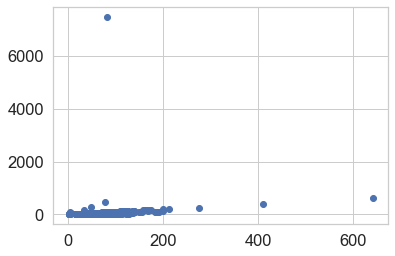

In [38]:
plt.scatter(train_df['Square'], train_df['LifeSquare']);

In [39]:
train_df[train_df['LifeSquare'].isna()].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11993,74,2.00,80.31,nan,0.00,14,0.00,1977,0.08,1,1,6,1437,3,900.00,0,2,1,"221,244.16"
5172,1,2.00,64.51,nan,1.00,9,17.00,1977,0.01,1,1,1,264,0,900.00,0,1,1,"229,102.80"
11935,27,2.00,64.71,nan,1.00,15,1.00,1977,0.21,1,1,9,1892,0,900.00,0,1,1,"127,200.03"
6641,999,3.00,118.91,nan,0.00,2,0.00,1977,0.01,1,1,30,5285,0,645.00,6,6,1,"571,069.05"
5073,74,2.00,82.67,nan,1.00,16,17.00,1977,0.08,1,1,6,1437,3,900.00,0,2,1,"244,145.83"


In [40]:
# train_df.loc[(train_df['LifeSquare'] > 250) | \
#             train_df['LifeSquare'].isna(),
#             'LifeSquare'] = train_df['LifeSquare'].median()

# test_df.loc[(test_df['LifeSquare'] > 250) | \
#            test_df['LifeSquare'].isna(),
#            'LifeSquare'] = train_df['LifeSquare'].median()

In [41]:
# train_df.loc[(train_df['LifeSquare'] > (train_df['Square'] * 1.5)) | \
#             (train_df['Square'] > 400),
#             'LifeSquare'] = train_df['LifeSquare'].median()

# test_df.loc[(test_df['LifeSquare'] > (test_df['Square'] * 1.5)) | \
#             (test_df['Square'] > 400),
#            'LifeSquare'] = train_df['LifeSquare'].median()

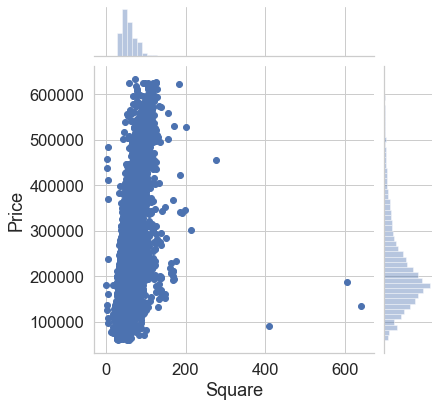

In [42]:
sns.jointplot(train_df['Square'], train_df['Price'], kind='scatter', height=6);

In [43]:
print((train_df['Square'] < 10).sum(), ' значений: общая площадь менее 10 кв.м')

12  значений: общая площадь менее 10 кв.м


In [44]:
# train_df.loc[(train_df['Square'] > 400) | (train_df['Square'] < 10), 'Square'] = \
#            train_df['Square'].median()

# test_df.loc[(test_df['Square'] > 400) | (test_df['Square'] < 10), 'Square'] = \
#            train_df['Square'].median()

In [45]:
len(train_df[(train_df['Square'] < (train_df['LifeSquare'] + train_df['KitchenSquare']))])

845

In [46]:
# train_df.loc[(train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare']), 'Square'] = \
#    train_df['LifeSquare'] + train_df['KitchenSquare']

# test_df.loc[(test_df['Square'] < test_df['LifeSquare'] + test_df['KitchenSquare']), 'Square'] = \
#    test_df['LifeSquare'] + test_df['KitchenSquare']

In [47]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","7,887.00","10,000.00"
mean,56.32,37.20,6.27
std,21.06,86.24,28.56
min,1.14,0.37,0.00
25%,41.77,22.77,1.00
50%,52.51,32.78,6.00
75%,65.90,45.13,9.00
max,641.07,"7,480.59","2,014.00"


**Floor, HouseFloor**

In [48]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [49]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [50]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

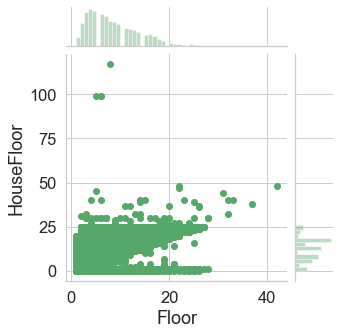

In [51]:
sns.jointplot(train_df['Floor'], train_df['HouseFloor'], kind='scatter', height=5, color='g');

In [52]:
# train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
# test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

# train_df.loc[train_df['HouseFloor'] > 98, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
# test_df.loc[test_df['HouseFloor'] > 98, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [53]:
# floor_outliers_train = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
# floor_outliers_test = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index

# train_df.loc[floor_outliers_train, 'Floor'] = \
#    train_df.loc[floor_outliers_train, 'HouseFloor'].apply(lambda x: random.randint(1, x))
# test_df.loc[floor_outliers_test, 'Floor'] = \
#    test_df.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

**HouseYear**

In [54]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [55]:
test_df['HouseYear'].sort_values().unique()

array([1908, 1909, 1910, 1911, 1912, 1914, 1917, 1918, 1920, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1937, 1938, 1939,
       1940, 1941, 1943, 1948, 1949, 1950, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [56]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020
test_df.loc[test_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### Анализ признаков

**Ecology_1**

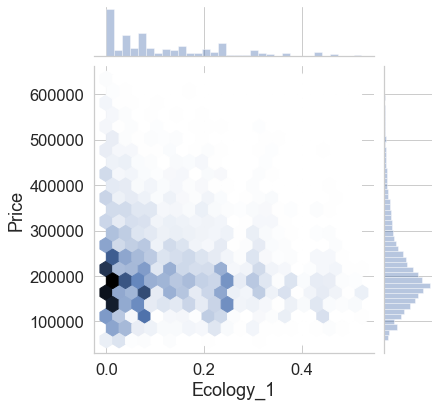

In [57]:
sns.jointplot(train_df['Ecology_1'], train_df['Price'], kind='hex', gridsize=20);

**Social_1, Social_2, Social_3, Healthcare_1**

Text(0.5, 1.0, 'Healthcare_1')

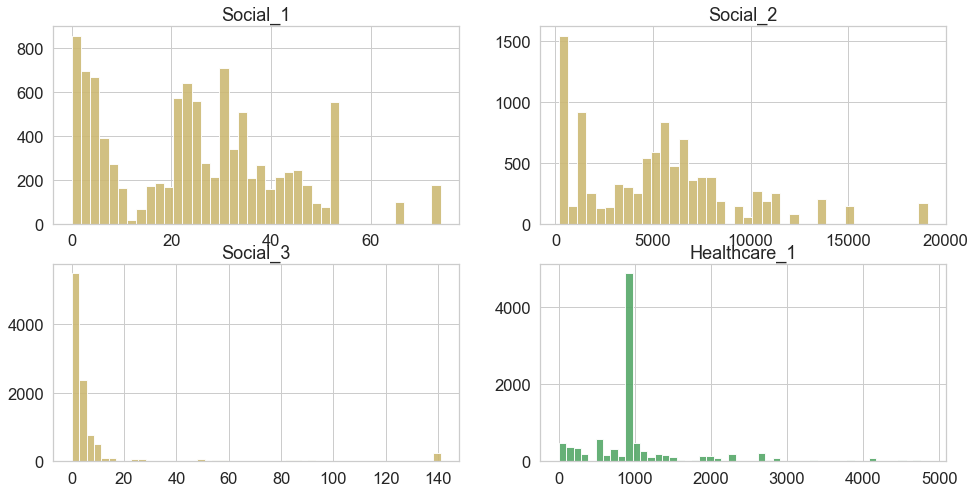

In [58]:
fig = plt.figure(figsize = (16, 8))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


ax1.hist(train_df['Social_1'], bins=40, color='y', alpha=0.9)
ax1.set_title('Social_1')

ax2.hist(train_df['Social_2'], bins=40, color='y', alpha=0.9)
ax2.set_title('Social_2')

ax3.hist(train_df['Social_3'], bins=50, color='y', alpha=0.9)
ax3.set_title('Social_3')

ax4.hist(train_df['Healthcare_1'], bins=50, color='g', alpha=0.9)
ax4.set_title('Healthcare_1')

In [60]:
# train_df['Social_3'].value_counts()

In [61]:
# train_df['Social_3'] = train_df['Social_3'].astype('category')
# test_df['Social_3'] = test_df['Social_3'].astype('category')

# train_df.info()

**Helthcare_2**

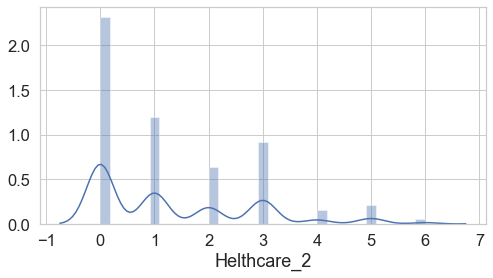

In [59]:
# dict(df['Healthcare_1'].value_counts().sort_values())
plt.figure(figsize = (8, 4))

sns.distplot(train_df['Helthcare_2'])

In [60]:
train_df['Helthcare_2'].value_counts().sort_values()

6      99
4     288
5     388
2    1158
3    1670
1    2183
0    4214
Name: Helthcare_2, dtype: int64

**Shops_1**

In [61]:
train_df['Shops_1'].value_counts().sort_values()

19      49
16      83
15     176
10     215
23     245
8      253
7      294
9      316
11     401
6      487
3      711
4      841
2      964
5     1324
1     1325
0     2316
Name: Shops_1, dtype: int64

### Построение новых признаков

DistrictSize - Размер района

In [65]:
# train_df = train_df.merge(district_size, on='DistrictId', how='left').set_index(train_df.index)
# test_df = test_df.merge(district_size, on='DistrictId', how='left').set_index(test_df.index)

PricePerMeter - Стоимость квадратного метра общей площади

In [66]:
# train_df['PricePerMeter'] = train_df['Price'] / train_df['Square']

RoomSquare - Жилая площадь одной комнаты

In [67]:
# train_df['RoomSquare'] = train_df['LifeSquare'] / train_df['Rooms']
# test_df['RoomSquare'] = test_df['LifeSquare'] / test_df['Rooms']

Floor_cat - Категория этажности дома

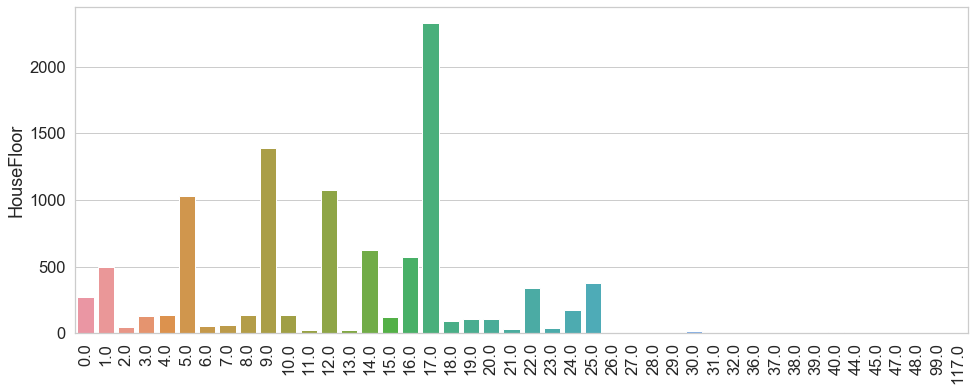

In [62]:
sns.set(style="whitegrid", font_scale=1.5)

f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y=train_df['HouseFloor'].value_counts(), 
            x=train_df['HouseFloor'].value_counts().index,
           )
ax.tick_params(axis='x', rotation=90);

In [69]:
# train_df.loc[train_df['HouseFloor'] <= 1, 'HouseFloor_cat'] = 1  
# train_df.loc[(train_df['HouseFloor'] > 1) & (train_df['HouseFloor'] <= 6), 'HouseFloor_cat'] = 2
# train_df.loc[(train_df['HouseFloor'] > 6) & (train_df['HouseFloor'] <= 12), 'HouseFloor_cat'] = 3
# train_df.loc[(train_df['HouseFloor'] > 12) & (train_df['HouseFloor'] <= 18), 'HouseFloor_cat'] = 4
# train_df.loc[train_df['HouseFloor'] > 18, 'HouseFloor_cat'] = 5

# test_df.loc[test_df['HouseFloor'] <= 1, 'HouseFloor_cat'] = 1  
# test_df.loc[(test_df['HouseFloor'] > 1) & (test_df['HouseFloor'] <= 6), 'HouseFloor_cat'] = 2
# test_df.loc[(test_df['HouseFloor'] > 6) & (test_df['HouseFloor'] <= 12), 'HouseFloor_cat'] = 3
# test_df.loc[(test_df['HouseFloor'] > 12) & (test_df['HouseFloor'] <= 18), 'HouseFloor_cat'] = 4
# test_df.loc[test_df['HouseFloor'] > 18, 'HouseFloor_cat'] = 5

In [70]:
# sns.catplot("HouseFloor_cat", "Price", kind="box", data=train_df, aspect=5/4);

HouseYear_cat - категория возраста дома

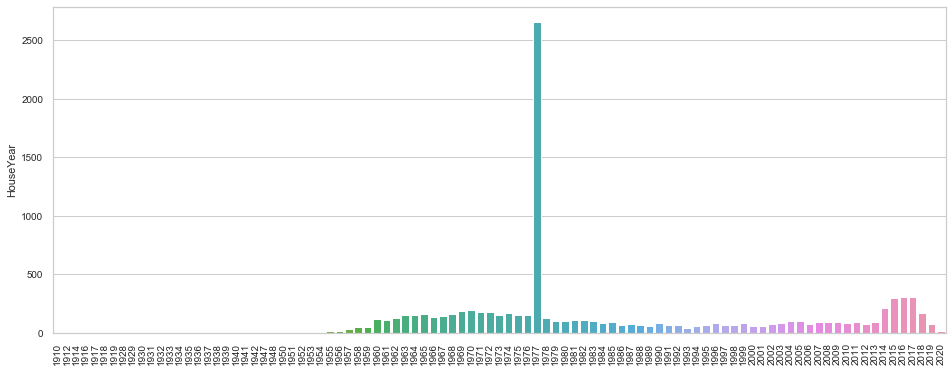

In [63]:
sns.set(style="whitegrid", font_scale=0.9)

f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y=train_df['HouseYear'].value_counts(), 
            x=train_df['HouseYear'].value_counts().index,
           )
ax.tick_params(axis='x', rotation=90);

In [64]:
(train_df['HouseYear'] == 1977).sum()

2652

In [65]:
(test_df['HouseYear'] == 1977).sum()

1298

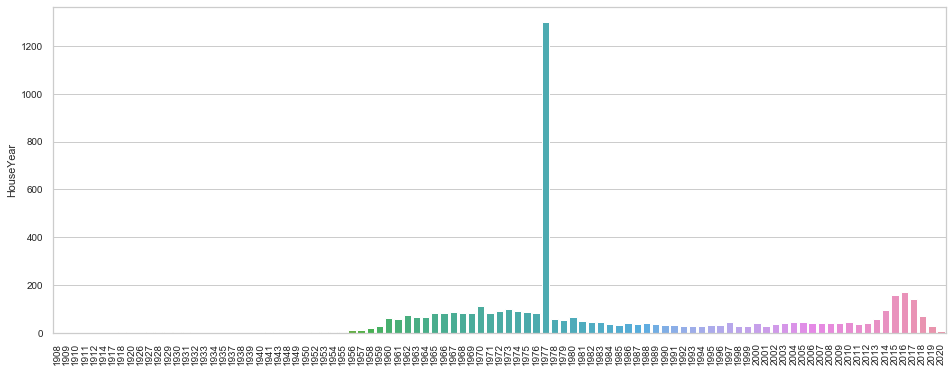

In [66]:
sns.set(style="whitegrid", font_scale=0.9)

f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y=test_df['HouseYear'].value_counts(), 
            x=test_df['HouseYear'].value_counts().index,
           )
ax.tick_params(axis='x', rotation=90);

In [75]:
# train_df['HouseAge'] = 2020 - train_df['HouseYear']
# test_df['HouseAge'] = 2020 - test_df['HouseYear']

In [76]:
#sns.set(style="whitegrid", font_scale=0.9)

#f, ax = plt.subplots(figsize=(16, 6))
#sns.barplot(y=train_df['HouseAge'].value_counts(), 
#            x=train_df['HouseAge'].value_counts().index,
#           )
#ax.tick_params(axis='x', rotation=90);

### Отбор признаков

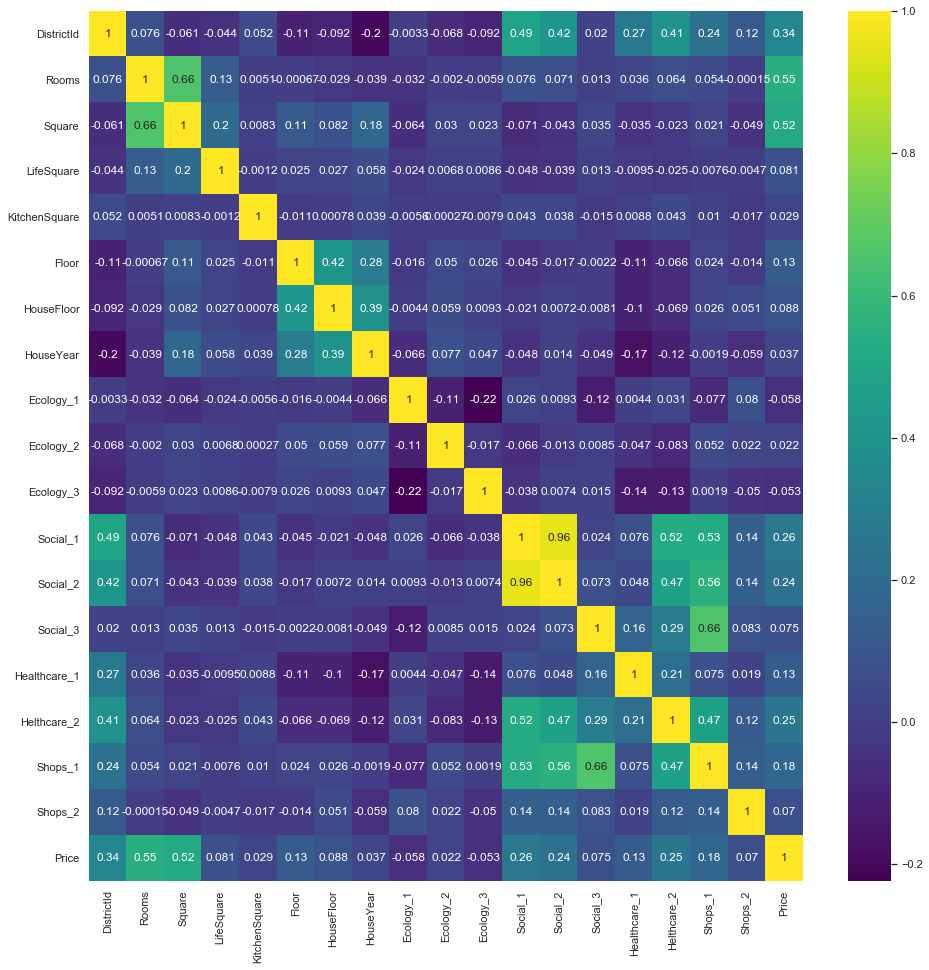

In [67]:
sns.set(style="whitegrid", font_scale=1)

f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(train_df.corr(), cmap= 'viridis', annot=True)

In [68]:
train_df.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2          int64
Ecology_3          int64
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2            int64
Price            float64
dtype: object

In [69]:
target_name = ['Price']
feature_names = [
             'DistrictId',
             'Rooms',
             'Square',
#             'LifeSquare',
             'KitchenSquare',
             'Floor',
             'HouseFloor',
             'HouseYear',
             'Ecology_1',
             'Ecology_2',
             'Ecology_3',
             'Social_1',
             'Social_2',
             'Social_3',
             'Healthcare_1',
             'Helthcare_2',
             'Shops_1',
             'Shops_2',
#             'Price',
#             'DistrictSize',
#             'PricePerMeter',
#                'RoomSquare',
#                'HouseFloor_cat',
#                'HouseAge'
]
feature_names

['DistrictId',
 'Rooms',
 'Square',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

In [70]:
X = train_df[feature_names]
y = train_df[target_name]

X_test = test_df[feature_names]

### Построение модели

**Перекрестная проверка модели**

In [71]:
forest = RandomForestRegressor(max_depth=19, 
                               max_features=6, 
                               n_estimators=400,
                               random_state=42)

In [72]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

cv_score = cross_val_score(forest, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))

R2: 0.75098


**Важность признаков**

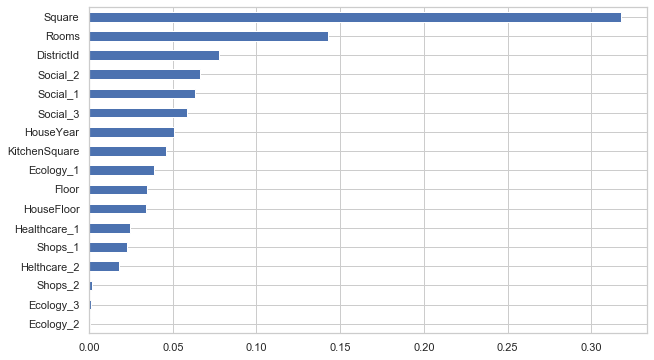

In [73]:
forest.fit(X, y)
importances = forest.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True, inplace=True)

feat_importances.plot(kind='barh', figsize=(10, 6));

### Настройка гиперпараметров Random Forest

In [75]:
params = {
    'n_estimators': [400],
    'max_depth': [18,19,20],
    'max_features': [5,6,7]
}

In [76]:
forest_grid = GridSearchCV(forest, params, scoring='r2', 
                  cv=KFold(n_splits=10, random_state=42, shuffle=True), 
                  n_jobs=-1)
forest_grid.fit(X, y)
print(forest_grid.best_params_)
print('R2 на train: {:.5f}'.format(forest_grid.best_score_))

{'max_depth': 19, 'max_features': 6, 'n_estimators': 400}
R2 на train: 0.75098


### Прогнозирование на тестовом датасете

In [77]:
forest_best = forest_grid.best_estimator_

y_pred = forest_best.predict(X_test)

In [78]:
preds = pd.DataFrame()
preds['Id'] = X_test.index
preds['Price'] = y_pred

preds.tail()

,Id,Price
4995,8180,"251,704.29"
4996,4695,"135,444.86"
4997,5783,"329,833.03"
4998,4780,"198,464.79"
4999,12504,"179,880.66"


In [79]:
preds.to_csv('Gurina_predictions.csv', index=False)
# preds.to_csv('submission.csv', index=False)

In [80]:
feature_names

['DistrictId',
 'Rooms',
 'Square',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']